<h1 style='color:green'>ABOUT</h1>

<p style='color:lightgreen'>These last decades, Earth Observation brought quantities of new perspectives from geosciences to human activity monitoring. As more data became available, artificial intelligence techniques led to very successful results for understanding remote sensing data. Moreover, various acquisition techniques such as Synthetic Aperture Radar (SAR) can also be used for problems that could not be tackled only through optical images. This is the case for weather-related disasters such as floods or hurricanes, which are generally associated with large clouds cover. Yet, machine learning on SAR data is still considered challenging due to the lack of available labeled data. This dataset is composed of co-registered optical and SAR images time series for the detection of flood events.</p>

[source](https://mlhub.earth/data/sen12floods)  

<h2 style='color:green'>Dataset</h2>

<p style='color:lightgreen'>The dataset is composed of 412
time series with 4 to 20 optical images and 10 to 58 SAR im-
ages in each sequence. On average, there are 9 optical and 14
SAR images per sequence. The period of acquisition goes from
December 2018 to May 2019. A flood event is occuring in 40%
of the optical Sentinel 2 images and in 47% of the SAR Sen-
tinel 1 images. As in the MediaEval dataset, once a flood oc-
curred in a sequence, all the subsequent images are labeled as
flooded which corresponds to the hypothesis that the surface
still presents characteristic modifications after the event.</p>

[source](https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLIII-B2-2020/1343/2020/isprs-archives-XLIII-B2-2020-1343-2020.pdf)  

<h2 style='color:green'>Other notebooks related to this project</h2>

    
* [Data Download](https://www.kaggle.com/code/virajkadam/detecting-flood-from-satellite-img-data-download)
    
* [The next notebook in this series(Time Series)](https://www.kaggle.com/virajkadam/detecting-floods-time-series-prediction)
    

# Imports

In [1]:
import json
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import gc
import rasterio as rio
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  cm
import cv2
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Config

In [3]:
class CFG:
    seed = 7
    img_size = (256,256)
    BATCH_SIZE = 3
    Autotune = tf.data.AUTOTUNE
    validation_size = 0.2
    class_dict= {0:'No Flooding', 
                 1: 'Flooding'}
    
    test_run = False 
    


# Input data

    Read more about the dataset here : https://clmrmb.github.io/SEN12-FLOOD/

In [4]:
s1_labels = '../input/sen12flood/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/'
s1_tiles = '../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source/'

s2_tiles = '../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source/'
s2_labels = '../input/sen12flood/sen12flood/sen12floods_s2_labels/sen12floods_s2_labels/'


s1_check = 0
for file in os.listdir(s1_labels):
    if os.path.exists(s1_tiles + '/' + file.replace('labels','source')):
        s1_check += 1
        
         
assert s1_check == len(os.listdir(s1_tiles)), 'You my friend , are definintely a idiot!'
    
s2_check = 0
for file in os.listdir(s2_labels):
    if os.path.exists(s2_tiles + '/' + file.replace('labels','source')):
        s2_check += 1
        
        
assert s2_check == len(os.listdir(s2_tiles)), 'You my friend , are definintely  the idiot!'


s1_check,s2_check 

(3332, 2237)

# Make a dataset of paths and labels

# Helper Functions

In [5]:
def load_json(path):
    '''loads a json file'''
    with open(path,'r') as file:
        js = json.load(file)
        
    return js

# collectionss1 = load_json('../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source/collection.json')
# collections2= load_json('../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source/collection.json')
# collections2

In [6]:
def process_label_json(label_json):
    '''process a single label json'''
    info_dict = {}
    
    info_dict['geometry'] = label_json['geometry']['coordinates']
    info_dict['label'] = label_json['properties']['FLOODING']
    info_dict['date'] = label_json['properties']['date']
    info_dict['tile_number'] = label_json['properties']['tile']
#     info_dict['full_data_coverage']= label_json['properties']['FULL-DATA-COVERAGE']
    
    return info_dict


def process_label_stac(stac_json):
    return stac_json['id']
    
    


def image_path_from_label_dir(image_parent_dir:str,
                              label_file :str)->str:
    
    return image_parent_dir + '/' + label_file.replace('labels','source')
    
    

def process_json(label_path,image_directory):
    '''get the data for a single example
     Inputs 
     label_path : path to the label folder 
     image_directory: path to the corresponding image directory'''
    
    

    #get image directory for that label
    folder_id = label_path.rsplit('/',1)[1]
    image_dir_path = image_path_from_label_dir(image_directory,folder_id)

    if not os.path.exists(image_dir_path):
        return {'File_not_found':image_dir_path}
    
    
    for file in os.listdir(label_path):
        #if image dir exists 
        if file.startswith('labels'):
            label_json = load_json(os.path.join(label_path,file))
        else:
            stac_json = load_json(os.path.join(label_path,file))


    #get data 
    info_dict = process_label_json(label_json)

    #get id 
    info_dict['id'] = process_label_stac(stac_json)
    
    #location id 
    info_dict['location_id'] = info_dict['id'].split('_')[3]
    
    
    info_dict['image_dir'] = image_dir_path
    
    
    return info_dict


In [7]:
def get_dataframe(label_directory,image_directory):
    '''get dataframe from the nested label directory'''
    records = []
    
        
    for folder in os.listdir(label_directory):
        if folder.startswith('sen12'):
#             print(folder,label_directory)
            folder_path = label_directory + '/' + folder
            
            
            #get data for a single example
            feature = process_json(label_path=folder_path,
                                   image_directory=image_directory)
            
            
            records.append(feature)
            
            
    return pd.DataFrame.from_records(data = records)



def type_cast_dataset(dataset):
    '''typecasting columns in dataset'''
    dataset['label'] = dataset['label'].astype(int)
    
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['tile_number'] = dataset['tile_number'].astype('int8')
    
    
    return dataset
    

In [8]:
%%time
s1_data = type_cast_dataset(
                            get_dataframe(
                                label_directory=s1_labels,
                                image_directory=s1_tiles
                                        )
                            )


s2_data = type_cast_dataset(
                            get_dataframe(label_directory=s2_labels,
                                          image_directory=s2_tiles)
                            )

print(f'Number of unique locations in Sentinel1 (SAR) data : {s1_data.location_id.nunique()}')
print(f'Number of unique locations in Sentinel2 (optical) data : {s2_data.location_id.nunique()}')

s1_data.shape,s2_data.shape

Number of unique locations in Sentinel1 (SAR) data : 335
Number of unique locations in Sentinel2 (optical) data : 335
CPU times: user 2.54 s, sys: 2.27 s, total: 4.8 s
Wall time: 54.3 s


((3331, 7), (2236, 7))

In [9]:
# saving datasets
s1_data.to_csv('s1_data.csv',index=False)
s2_data.to_csv('s2_data.csv',index=False)

In [10]:
def load_raster(filepath):
    '''load a single band raster'''
    with rio.open(filepath) as file: 
        raster = file.read().squeeze(axis=0)
        
    return raster



**Loading multiple raster bands as single raster**

In [11]:
def load_s1_tiffs(folder,
                  scaling_values=[50.,100.]):
    images = []
    i = 0
    for im in sorted(os.listdir(folder)):
         
        if im.rsplit('.',maxsplit=1)[1] == 'tif':
            
            path = folder + '/' + im
            band = load_raster(path)
            band = band / scaling_values[i]
            
            band = cv2.resize(band,
                              CFG.img_size)
            
            images.append(band)
            i+=1 
                    
    return np.dstack(images)


def load_s2_tiffs(folder,
                  scaling_value=10000.):
    images = []
    for im in sorted(os.listdir(folder)):
        if im.rsplit('.',maxsplit=1)[1] == 'tif':    
            path = folder + '/' + im
            band = load_raster(path)
            band = band/ scaling_value
            
            band = cv2.resize(band,CFG.img_size)
            images.append(band)   

    return np.dstack(images)
                    
def load_rgb_tiffs(folder,
                  scaling_value=10000.):
    '''load R,G and B bands'''
    
    images = []
    for im in sorted(os.listdir(folder)):
        name,file_format = im.rsplit('.',maxsplit=1)
        if ((file_format== 'tif') and (name in ['B02','B03','B04'])):    
            path = folder + '/' + im
            band = load_raster(path)
            band = band/ scaling_value
            
            band = cv2.resize(band,CFG.img_size)
            images.append(band)   

    return np.dstack(images)[:,:,::-1]


    
def tf_load_s1(path):    
    path = path.numpy().decode('utf-8')
    return load_s1_tiffs(path)
    
    

def tf_load_s2(path):    
    path = path.numpy().decode('utf-8')
    return load_s2_tiffs(path)


def tf_load_rgb(path):    
    path = path.numpy().decode('utf-8')
    return load_rgb_tiffs(path)
    
def process_image_s1(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_s1, 
                          [filename], 
                          tf.float32)



def process_image_s2(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_s2, 
                          [filename], 
                          tf.float32)



def process_image_rgb(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_rgb, 
                          [filename], 
                          tf.float32)
    

In [12]:
def count_rasters_in_folder(path):
    count = 0 
    
    for file in os.listdir(path):
        if file.rsplit('.',1)[1] == 'tif':
            count +=1 
            
    return count 
    
    
s2_data['raster_count'] = s2_data.image_dir.apply(lambda x : count_rasters_in_folder(x))

#value counts 
s2_data['raster_count'].value_counts()


s2_data=s2_data[s2_data['raster_count']==12] # take only valid rasters
# s2_data[s2_data['raster_count']==0]['location_id'].value_counts()

# Visualize some images

**lets take a look at some optical RGB images**

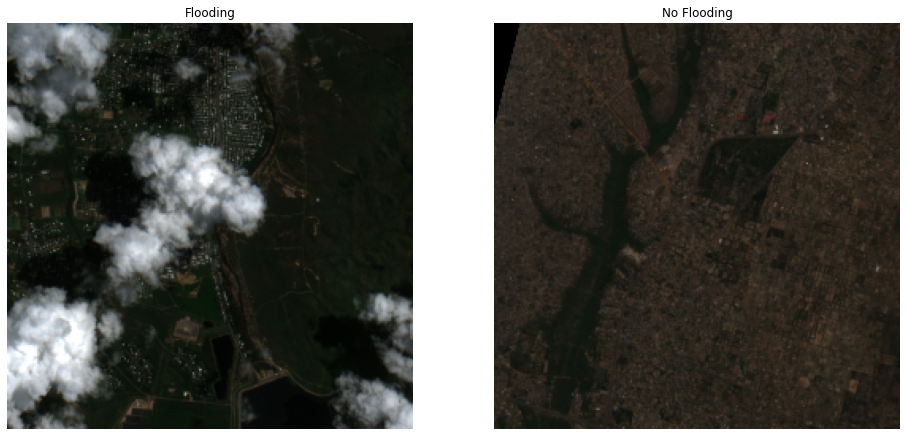

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
chk = load_s2_tiffs(s2_data.query('label==1')['image_dir'].values[11])
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[20])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('No Flooding')
plt.axis('off')
plt.show()

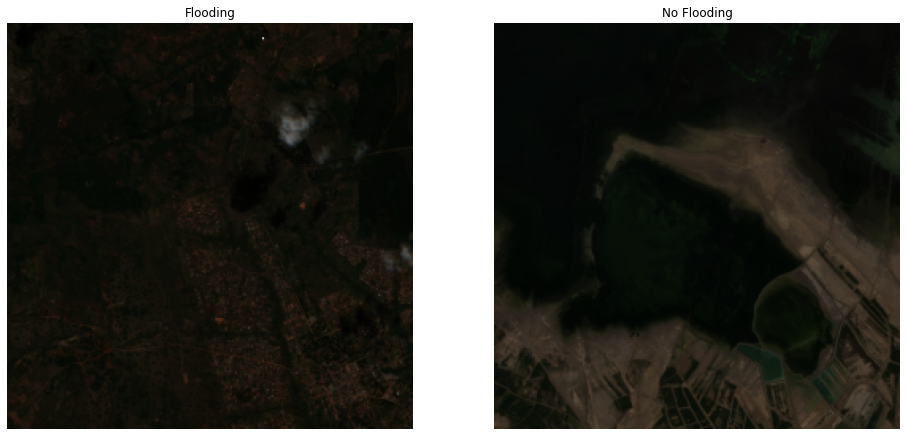

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
chk = load_s2_tiffs(s2_data.query('label==1')['image_dir'].values[101])
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[11])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('No Flooding')
plt.axis('off')
plt.show()

**Some SAR images**

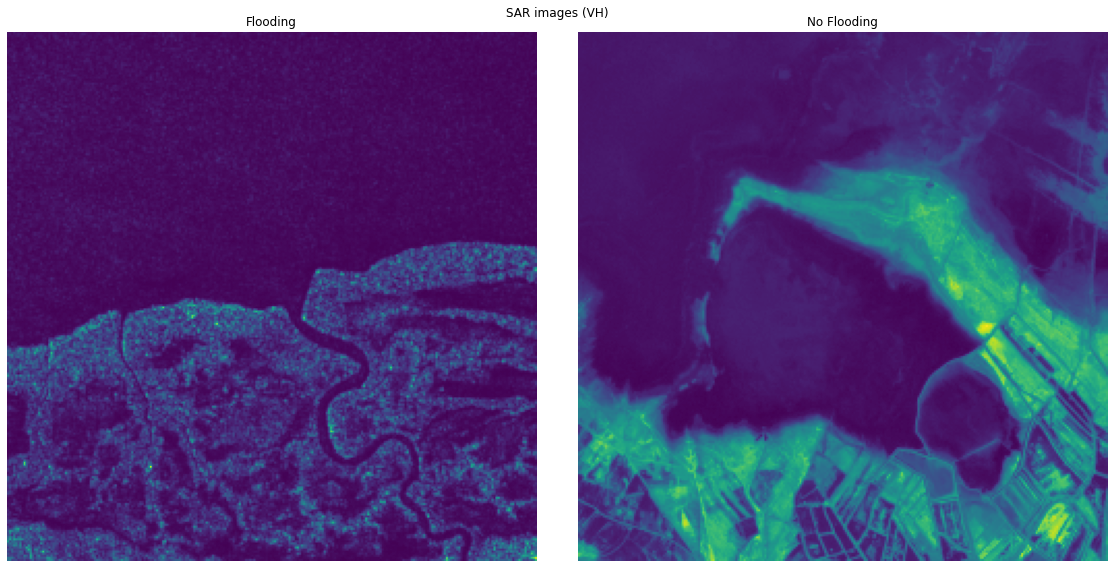

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.suptitle('SAR images (VH)')

plt.subplot(1,2,1)


chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[11])
plt.imshow(chk[:,:,1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[11])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1])
plt.title('No Flooding')
plt.axis('off')

plt.tight_layout()
plt.show()


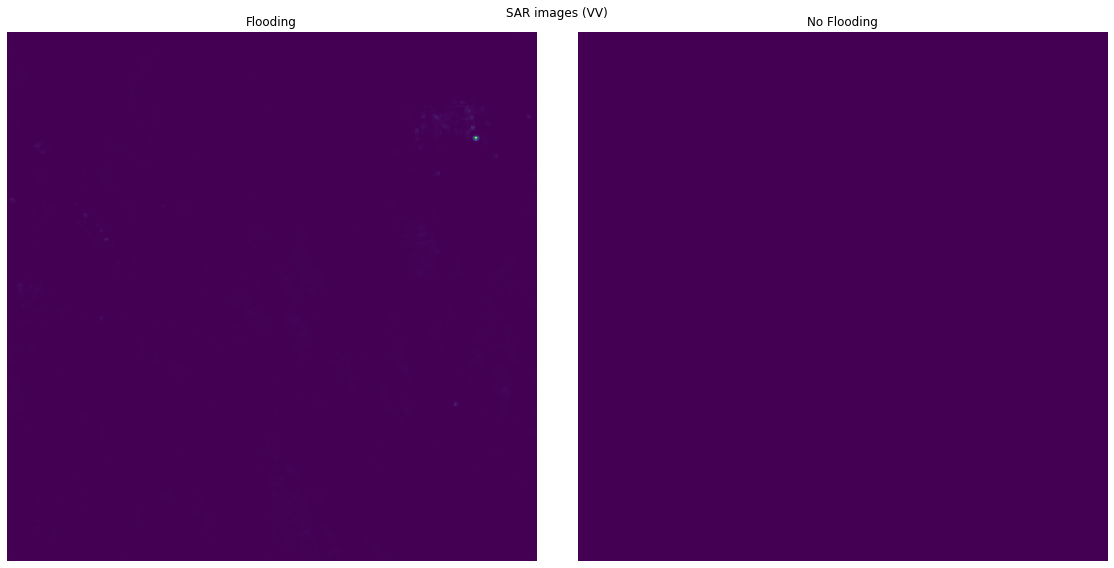

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
plt.suptitle('SAR images (VV)')


r_idx = np.random.randint(low=0,high=500)
plt.subplot(1,2,1)
chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[r_idx])
plt.imshow(chk[:,:,0])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[r_idx])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,0])
plt.title('No Flooding')
plt.axis('off')
plt.tight_layout()

plt.show()

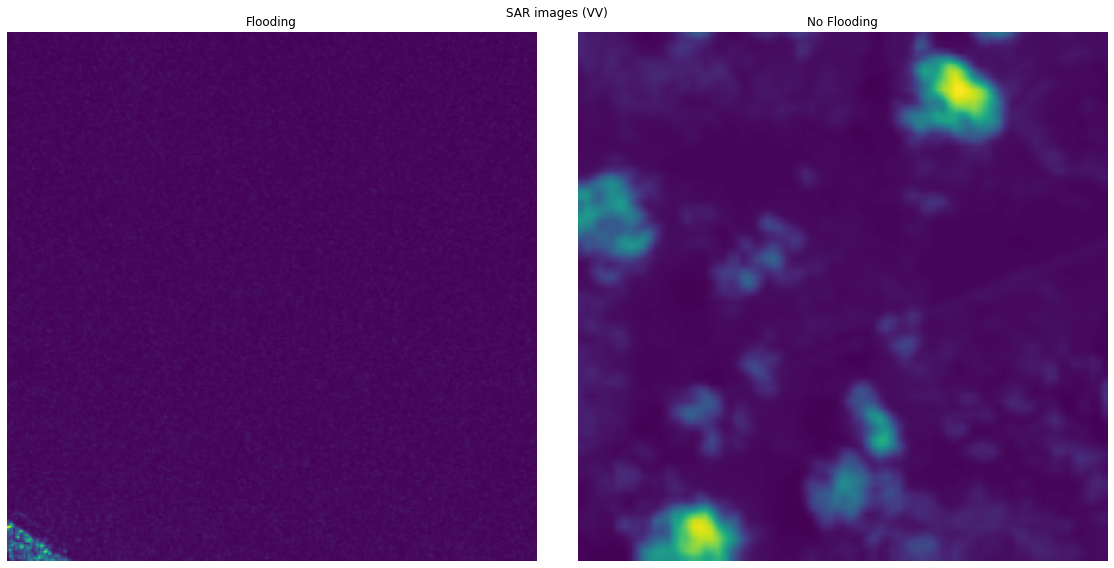

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
plt.suptitle('SAR images (VV)')


r_idx = np.random.randint(low=0,high=500)
plt.subplot(1,2,1)
chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[r_idx])
plt.imshow(chk[:,:,0])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[r_idx])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,0])
plt.title('No Flooding')
plt.axis('off')
plt.tight_layout()

plt.show()

**Lets look at the distribution of target values**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


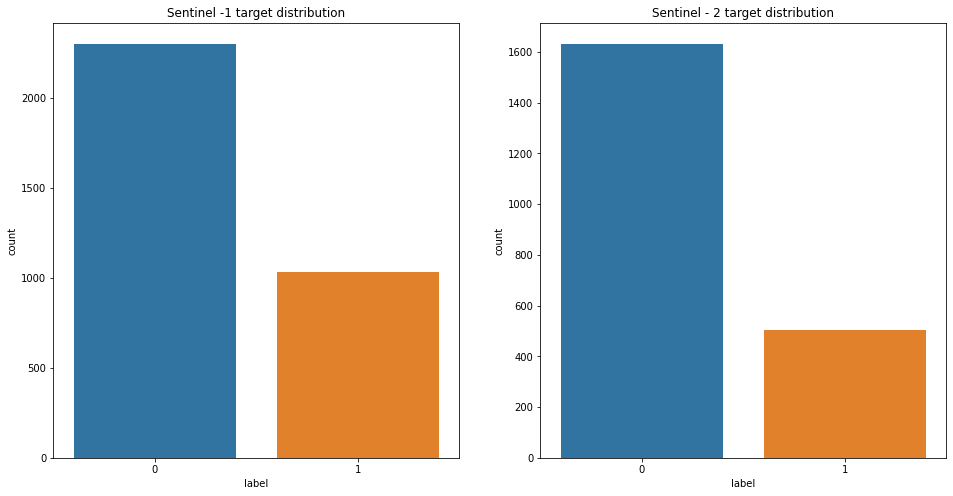

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
sns.countplot(s1_data.label)
plt.title('Sentinel -1 target distribution')


plt.subplot(1,2,2)
sns.countplot(s2_data.label)
plt.title('Sentinel - 2 target distribution')
plt.show()

# Making a TF dataset

    First lets split the dataset into training and validation set. We will stratify based on location id to ensure that locations are well represented in traininng and validation set

In [19]:
#isolating single loaction ids (as they will be a problem for stratification)

# single example locations 
single_index = s2_data['location_id'].value_counts()[s2_data['location_id'].value_counts()==1].index

single_index_df = s2_data[s2_data['location_id'].isin(single_index)].reset_index(drop=True)
s2_data0 = s2_data[~(s2_data['location_id'].isin(single_index))].reset_index(drop=True)

s2_data0.shape,single_index_df.shape

((2126, 8), (12, 8))

**Split dataset into train and validation splits**

In [20]:
#traintest split 

s1_data_tr,s1_data_val= train_test_split(s1_data,
                                          test_size = CFG.validation_size,
                                          random_state = CFG.seed,
                                          stratify = s1_data.location_id)



s2_data_tr,s2_data_val = train_test_split(s2_data0,
                                          test_size = CFG.validation_size,
                                          random_state = CFG.seed,
                                          stratify =  s2_data0.location_id)

s2_data_tr = s2_data_tr.append(single_index_df,ignore_index=True)

del s2_data0;gc.collect()

0

In [21]:
s1_data_tr.label.value_counts(1),s1_data_val.label.value_counts(1)

(0    0.69482
 1    0.30518
 Name: label, dtype: float64,
 0    0.673163
 1    0.326837
 Name: label, dtype: float64)

In [22]:
s2_data_tr.label.value_counts(1),s2_data_val.label.value_counts(1)

(0    0.773364
 1    0.226636
 Name: label, dtype: float64,
 0    0.725352
 1    0.274648
 Name: label, dtype: float64)

**Function for image augmentations**

    Although the Augmentations are simple, we cannot use them on SAR images , as even simple operations like flipping can change the meaning of the image

In [23]:
def augment_image_multispectral(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size,12))
    
    rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image 

def augment_image(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size,3))
    
    rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image 

In [24]:
def get_tf_dataset(image_paths,
                   labels=None, # put none for test data set
                   image_processing_fn=None,
                   augment_fn = None
                  ):
    
    '''returns a tf dataset object
    Inputs: 
    image_paths : paths to images
    labels: labels of each image
    image_processing_fn:  function to load and preprocess images 
    augment_fn : function to augment images '''
    
    #seperate datasets
    if labels is not None:
        labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #load images 
    image_dataset = image_dataset.map(image_processing_fn,
                                      num_parallel_calls=tf.data.AUTOTUNE)
     
    if augment_fn is not None:
        
        image_dataset = image_dataset.map(augment_fn,
                                          num_parallel_calls=tf.data.AUTOTUNE)
     
    
    if labels is not None:
        return tf.data.Dataset.zip((image_dataset,labels_dataset))
    
    
    return image_dataset



def optimize_pipeline(tf_dataset,
                      batch_size = CFG.BATCH_SIZE,
                      Autotune_fn = CFG.Autotune,
                      cache= False,
                      batch = True):
    
    
    
    # prefetch(load the data with cpu,while gpu is training) the data in memory 
    tf_dataset = tf_dataset.prefetch(buffer_size=Autotune_fn)  
    if cache:
        tf_dataset = tf_dataset.cache()                        # store data in RAM  
        
    tf_dataset =  tf_dataset.shuffle(buffer_size=50)         # shuffle 
    
    if batch:
        tf_dataset = tf_dataset.batch(batch_size)              #split the data in batches  
    
    return tf_dataset

**Making dataset pipelines with TF data**

In [25]:
# Sentinel 1 dataset (not using augmentation here)

S1_dataset_tr = optimize_pipeline(tf_dataset=get_tf_dataset(image_paths = s1_data_tr.image_dir.values,
                                               labels = s1_data_tr.label,
                                               image_processing_fn = process_image_s1),
                                  
                                  batch_size = 3 * CFG.BATCH_SIZE)


S1_dataset_val = optimize_pipeline(tf_dataset = get_tf_dataset(image_paths = s1_data_val.image_dir.values,
                                                           labels = s1_data_val.label,
                                                           image_processing_fn = process_image_s1 ),
                                   batch_size = 3* CFG.BATCH_SIZE
                                  )

In [26]:
#sentinel 2 dataset 
S2_dataset_tr = optimize_pipeline(get_tf_dataset(image_paths = s2_data_tr.image_dir.values,
                                                   labels = s2_data_tr.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                 )


S2_dataset_val = optimize_pipeline(get_tf_dataset(image_paths = s2_data_val.image_dir.values,
                                                   labels = s2_data_val.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                  )




In [27]:
RGB_dataset_tr = optimize_pipeline(get_tf_dataset(image_paths = s2_data_tr.image_dir.values,
                                                   labels = s2_data_tr.label,
                                                   image_processing_fn = process_image_rgb,
                                                   augment_fn = augment_image),
                                   batch_size = 3* CFG.BATCH_SIZE
                                 )


RGB_dataset_val = optimize_pipeline(get_tf_dataset(image_paths = s2_data_val.image_dir.values,
                                                   labels = s2_data_val.label,
                                                   image_processing_fn = process_image_rgb,
                                                   augment_fn = augment_image),
                                    batch_size = 3* CFG.BATCH_SIZE
                                  )



**Checking the values of pixels in the dataset**

In [28]:

# max_vals_vv = []
# mean_vals_vv =[]


# max_vals_vh = []
# mean_vals_vh =[]

# for x,y in S1_dataset_tr.as_numpy_iterator():
#     # vv band 
#     max_vals_vv.append(x[:,:,:,0].max()); mean_vals_vv.append(x[:,:,:,0].mean())
    
#     # vh band 
#     max_vals_vh.append(x[:,:,:,1].max()); mean_vals_vh.append(x[:,:,:,1].mean())
    
# # band 1value distributions 
# plt.figure(figsize=(16,10))

# sns.distplot(max_vals_vv,label = 'VV band Max values',color='b')
# # sns.distplot(mean_vals_vv,label = 'VV band Mean values',color = 'g')

# plt.legend()

# plt.title('VV band values Distribution')
# plt.show()

# # band 1value distributions 
# plt.figure(figsize=(16,10))

# sns.distplot(max_vals_vh,label = 'VH band Max values',color='b')
# # sns.distplot(mean_vals_vh,label = 'VH band Mean values',color = 'g')


# plt.title('VH band values Distribution')

# plt.legend()
# plt.show()

**Checking to see if the Pipelines work as expected**

In [29]:
for x,y in S1_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of SAR dataset input {x.shape}')

shape of SAR dataset input (9, 256, 256, 2)


In [30]:
for x,y in S2_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of MultiSpectral dataset input {x.shape}')

shape of MultiSpectral dataset input (3, 256, 256, 12)


In [31]:
for x,y in RGB_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of MultiSpectral dataset input {x.shape}')

shape of MultiSpectral dataset input (9, 256, 256, 3)


#  CNN Models
    CNN models to identify flooding in opotical and SAR images

In [32]:
def multichannel_cnn(num_channels:int,
                     hidden_units:int, #number of  hidden dense 
                     weights = None  # none for random init, use imagenet for imagenet weights 
                    ):
    '''model that takes multiple channel as input, instead of using the rgb channels as by default'''
    
    
    backbone = tf.keras.applications.resnet_v2.ResNet50V2(
                                            include_top=False,
                                            input_shape = (*CFG.img_size,num_channels),
                                            weights=weights,
                                            pooling = 'avg')
    
    
    x = tf.keras.layers.BatchNormalization()(backbone.output)
    x = tf.keras.layers.Dense(hidden_units,
                              activation = 'relu')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate = 0.2)(x)

    
    
    
    final_out = tf.keras.layers.Dense(2,
                                      activation = 'softmax')(x)
    
    
    #make a model 
    model = tf.keras.Model(inputs = backbone.input, 
                  outputs = final_out)
    
    return model 


# plot train and val acc as  a function of epochs
def plot_history(history,addn_metric=None):
    '''
    Inputs
    history:history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)
    
    if addn_metric:
        plt.subplots(1,3,figsize=(20,6))
        
        #loss:
        ax1=plt.subplot(1,3,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,3,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

    
        
        ax3= plt.subplot(1,3,3)
        ax3.plot(range(len(his)),his[f'{addn_metric}'],color='g',label='training')
        ax3.plot(range(len(his)),his[f'val_{addn_metric}'],color='r',label='validation')
        ax3.set_xlabel('EPOCHS')
        ax3.set_ylabel(f'{addn_metric}')
        ax3.legend()
        ax3.set_title(f'{addn_metric} Per Epoch')

        
    else:
        plt.subplots(1,2,figsize=(20,8))
        
    
    
        #loss:
        ax1=plt.subplot(1,2,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,2,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

        
    
    
    plt.show()  

# Metrics 

In [33]:


#from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Building and training the SAR CNN

In [34]:
SAR_CNN = multichannel_cnn(num_channels = 2,
                           hidden_units = 512, #number of  hidden dense 
                          )



SAR_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy',f1_score,recall_m,precision_m]
               )

#check on some data 
# SAR_CNN(x)



!mkdir CNN_models

/opt/conda/lib/python3.7/site-packages/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


# Defining callbacks

In [35]:
EPOCHS = 2 if CFG.test_run else 75
# callbacks 
#reduce_learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=3,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                mode='max')

#early stopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                              min_delta=1e-3,
                                              monitor='val_accuracy',
                                              restore_best_weights=True,
                                              mode='max')


# exponential decay 

def lr_scheduler(epoch, lr):
    '''learning rate scheduler, decays expo after the tenth epoch'''

    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    

    
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)


callbacks_1= [reduce_lr,early_stopping,learning_scheduler]

**Training on SAR data**

Epoch 1/75
296/296 [==============================] - 940s 3s/step - loss: 0.6953 - accuracy: 0.6558 - f1_score: 0.4436 - recall_m: 0.9493 - precision_m: 0.3052 - val_loss: 0.6323 - val_accuracy: 0.6732 - val_f1_score: 0.4694 - val_recall_m: 0.9467 - val_precision_m: 0.3230
Epoch 2/75
296/296 [==============================] - 920s 3s/step - loss: 0.5931 - accuracy: 0.7162 - f1_score: 0.4470 - recall_m: 0.9662 - precision_m: 0.3052 - val_loss: 0.6386 - val_accuracy: 0.6732 - val_f1_score: 0.4661 - val_recall_m: 0.9600 - val_precision_m: 0.3230
Epoch 3/75
296/296 [==============================] - 913s 3s/step - loss: 0.5606 - accuracy: 0.7395 - f1_score: 0.4465 - recall_m: 0.9628 - precision_m: 0.3052 - val_loss: 0.9743 - val_accuracy: 0.3958 - val_f1_score: 0.4688 - val_recall_m: 0.9867 - val_precision_m: 0.3230
Epoch 4/75
296/296 [==============================] - 914s 3s/step - loss: 0.5824 - accuracy: 0.7324 - f1_score: 0.4450 - recall_m: 0.9459 - precision_m: 0.3052 - val_loss: 0.

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


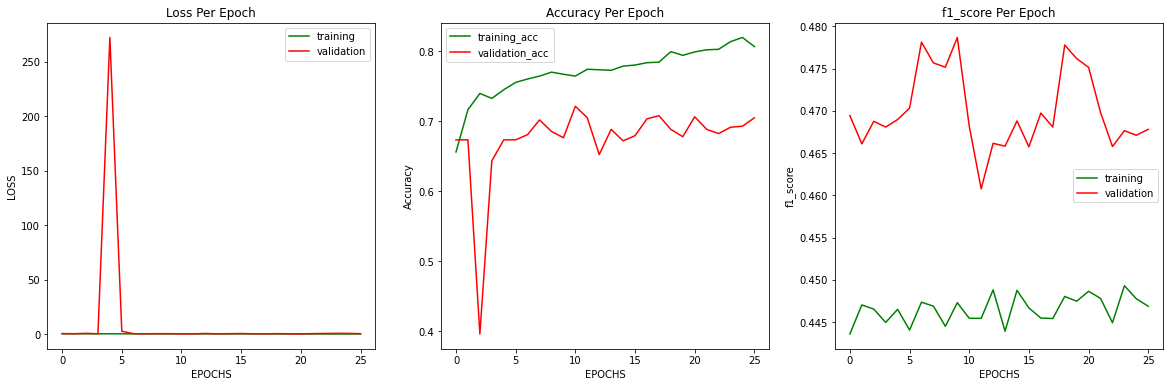

In [36]:
hist1 = SAR_CNN.fit(S1_dataset_tr,
                    validation_data = S1_dataset_val,
                    epochs = EPOCHS,
                    callbacks = callbacks_1
                   )


#save model
sar_model_path = 'CNN_models/SAR_CNN.h5'
SAR_CNN.save(filepath = 'CNN_models/SAR_CNN.h5')


#plot history 
plot_history(hist1,'f1_score')

****Evaluate on validation dataset****

In [37]:
SAR_CNN.evaluate(S1_dataset_val)

del SAR_CNN;gc.collect()

K.clear_session()

75/75 [==============================] - 60s 792ms/step - loss: 0.5276 - accuracy: 0.7211 - f1_score: 0.4640 - recall_m: 0.9600 - precision_m: 0.3230


# Model explainablity 

    Saliency and Grad Cam. Lets look at what the model is looking at while making htat decision

In [ ]:
!pip install tf_keras_vis -q
import tf_keras_vis 

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


tf_keras_vis.__version__


def model_modifier_function(cloned_model):
    '''modify model activation'''
    cloned_model.layers[-1].activation = tf.keras.activations.linear

    
def get_saliency(img,
                 score,
                 cnn_model,
                 model_modifier=model_modifier_function):
    #saliency map
    

    # Create Saliency object.
    saliency = Saliency(cnn_model,
                        model_modifier=model_modifier_function,
                        clone=True)
    #saliency map 
    sal_map  = saliency(score,
                        img,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
    return sal_map

def get_gradcam(img,
                score,
                cnn_model,
                model_modifier=model_modifier_function):

    # Create Gradcam object
    gradcam = Gradcam(cnn_model,
                      model_modifier,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  img,
                  seek_penultimate_conv_layer=True)
    
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    
    return heatmap

def get_gradcam_plus(img,
                    score,
                    model,
                    model_modifier=ReplaceToLinear()):
    
    # Create GradCAM++ object
    gradcam = GradcamPlusPlus(model,
                          model_modifier=model_modifier,
                          clone=True)
    
    cam = gradcam(score,
                  img)
    
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    return heatmap

In [ ]:
SAR_CNN = tf.keras.models.load_model('CNN_models/SAR_CNN.h5',
                                     custom_objects={'f1_score':f1_score,
                                                     'recall_m':recall_m,
                                                     'precision_m':precision_m}
                                    )

In [ ]:


plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1


for images,labels in S1_dataset_val.shuffle(buffer_size=5).take(1):
    print(images.shape,labels.shape)

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())
        
        #predict on image
        pred = np.argmax(SAR_CNN.predict(img[tf.newaxis,:,:,:]))
        prd = int(pred.ravel())

        score1 = CategoricalScore(lab)

        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img[:,:,0])
        idx+=1

        #saliency

        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]} (saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = SAR_CNN).squeeze(axis=0)
        
#         print(sal.shape)
        plt.axis('off')
        plt.imshow(img[:,:,0])
        plt.imshow(sal,alpha=0.25,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = SAR_CNN)
        plt.imshow(img[:,:,0])
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = SAR_CNN)
        plt.imshow(img[:,:,0])
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()

In [ ]:
plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1

for images,labels in S1_dataset_val.shuffle(buffer_size=5).take(1):
    print(images.shape,labels.shape)

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())
     
        #predict on image
        pred = np.argmax(SAR_CNN.predict(img[tf.newaxis,:,:,:]))
        score1 = CategoricalScore(lab)
        prd = int(pred.ravel())

        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img[:,:,1])
        idx+=1
        #saliency
        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]} (saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = SAR_CNN).squeeze(axis=0)
        
        plt.axis('off')
        plt.imshow(img[:,:,1])
        plt.imshow(sal,alpha=0.25,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = SAR_CNN)
        plt.imshow(img[:,:,1])
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = SAR_CNN)
        plt.imshow(img[:,:,1])
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()

In [ ]:
#delete 
del SAR_CNN;S1_dataset_val;S1_dataset_tr;gc.collect()

K.clear_session()

# Building and training the RGB - CNN

In [ ]:
RGB_CNN = multichannel_cnn(num_channels = 3,
                           hidden_units = 512, #number of  hidden dense
                           weights = 'imagenet'
                          )


RGB_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy',f1_score,recall_m,precision_m])

In [ ]:
hist2 = RGB_CNN.fit(RGB_dataset_tr,
                    validation_data = RGB_dataset_val,
                    epochs = EPOCHS,
                    callbacks = callbacks_1)

#save model

RGB_CNN.save(filepath = 'CNN_models/RGB_CNN.h5')

plot_history(hist2,'f1_score')

**Checking the GradCAM and saliency Maps for RGB CNN**

In [ ]:


plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1


for images,labels in RGB_dataset_val.shuffle(buffer_size=12).take(1):

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())


#         print(img.shape,lab.shape)
        score1 = CategoricalScore(lab)



        #predict on image
        prd= np.argmax(RGB_CNN.predict(img[tf.newaxis,:,:,:]))


        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img)
        idx+=1

        #saliency

        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]}(saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = RGB_CNN).squeeze(axis=0)
        
#         print(sal.shape)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = RGB_CNN)
        plt.imshow(img)
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = RGB_CNN)
        plt.imshow(img)
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()


In [ ]:
plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1


for images,labels in RGB_dataset_val.shuffle(buffer_size=12).take(1):

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())


#         print(img.shape,lab.shape)
        score1 = CategoricalScore(lab)



        #predict on image
        prd= np.argmax(RGB_CNN.predict(img[tf.newaxis,:,:,:]))


        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img)
        idx+=1

        #saliency

        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]}(saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = RGB_CNN).squeeze(axis=0)
        
#         print(sal.shape)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = RGB_CNN)
        plt.imshow(img)
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = RGB_CNN)
        plt.imshow(img)
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()



In [ ]:
#delete 
del RGB_CNN;gc.collect()

K.clear_session()

# Building and training the Multispectral - CNN

In [ ]:
multispectral_CNN = multichannel_cnn(num_channels = 12,
                                    hidden_units = 512, #number of  hidden dense 
                                    )


#check on some data 
# multispectral_CNN(x)


multispectral_CNN.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001,momentum = 0.0),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy',f1_score,recall_m,precision_m])

In [ ]:

hist2 = multispectral_CNN.fit(S2_dataset_tr,
                    validation_data = S2_dataset_val,
                    epochs = EPOCHS,
                    callbacks = callbacks_1)

#save model

multispectral_CNN.save(filepath = 'CNN_models/S2_CNN.h5')

plot_history(hist2,'f1_score')

**Checking the decision mechanism for Multispectral model**

In [ ]:


plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1


for images,labels in S2_dataset_val.shuffle(buffer_size=12).take(1):
    print(images.shape,labels.shape)

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())


#         print(img.shape,lab.shape)
        score1 = CategoricalScore(lab)



        #predict on image
        prd= np.argmax(multispectral_CNN.predict(img[tf.newaxis,:,:,:]))


        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img[:,:,1:4][:,:,::-1])
        idx+=1

        #saliency

        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]}(saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = multispectral_CNN).squeeze(axis=0)
        
#         print(sal.shape)
        plt.axis('off')
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = multispectral_CNN)
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = multispectral_CNN)
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()



In [ ]:


plt.subplots(4,4,figsize=(8*3,8*3))
n = 4
idx= 1


for images,labels in S2_dataset_val.shuffle(buffer_size=12).take(1):
    print(images.shape,labels.shape)

    for i in range(4):
        #get label 
        img = images[i]
        lab = int(labels[i].numpy())


#         print(img.shape,lab.shape)
        score1 = CategoricalScore(lab)



        #predict on image
        prd= np.argmax(multispectral_CNN.predict(img[tf.newaxis,:,:,:]))


        plt.subplot(4,4,idx)
        plt.title(f'orignal image ({CFG.class_dict[lab]})')
        plt.axis('off')
        plt.imshow(img[:,:,1:4][:,:,::-1])
        idx+=1

        #saliency

        plt.subplot(4,4,idx)
        plt.title(f'predicted {CFG.class_dict[prd]}(saliency map)')
        sal = get_saliency(img,
                           score1,
                           cnn_model = multispectral_CNN).squeeze(axis=0)
        
#         print(sal.shape)
        plt.axis('off')
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(sal,alpha=0.30,cmap='jet') #overlay
        idx+=1

        #gradcam
        plt.subplot(4,4,idx)
        gdcam = get_gradcam(img,
                            score1,
                           cnn_model = multispectral_CNN)
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam)')
        plt.axis('off')
        idx+=1


        #gradcam ++
        plt.subplot(4,4,idx)
        gdcam_pls = get_gradcam_plus(img,
                                     score1,
                                     model = multispectral_CNN)
        plt.imshow(img[:,:,1:4][:,:,::-1])
        plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
        plt.title(f'predicted {CFG.class_dict[prd]}(gradcam + +)')
        plt.axis('off')
        idx+=1

        if idx>16:
            break

    plt.tight_layout()
    plt.show()


# Model for temporal forecasting

    This notebooks covered the prediction of flooding using satellite images. But this dataset is as time series dataset, which has multiple images of locations before and during the flood. So we will try to cover the temporal aspect of predicting flooding in the next notebook. This can be especially important in some cases where there are water bodies in the image, and hence there needs to be additional signal to distinguish cases of flooding ffrom normal conditions
    
[The temporal forecasting notebook can be found here](https://www.kaggle.com/code/virajkadam/detecting-floods-time-series-prediction)

# References and resources 

* https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLIII-B2-2020/1343/2020/isprs-archives-XLIII-B2-2020-1343-2020.pdf
* https://arxiv.org/pdf/2006.10027v1.pdf#page=2